## Programming Exercise 3: Multi-class Classification and Neural Networks

In [72]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
from scipy.special import expit #Vectorized sigmoid function

### 1 Multi-class Classification

#### 1.1 Dataset

In [73]:
datafile = 'data/ex3data1.mat'
mat = scipy.io.loadmat( datafile )
print mat
X, y = mat['X'], mat['y']
#Insert a column of 1's to X as usual
X = np.insert(X,0,1,axis=1)
print "'y' shape: %s. Unique elements in y: %s"%(mat['y'].shape,np.unique(mat['y']))
print "'y' shape: %s. Unique elements in y: %s"%(mat['y'].shape,np.unique(y))
print "'X' shape: %s. X[0] shape: %s"%(X.shape,X[0].shape)
#X is 5000 images. Each image is a row. Each image has 400 pixels unrolled (20x20)
#y is a classification for each image. 1-10, where "10" is the handwritten "0"
print 'X: ',X[:20]
print 'y: ',y[:20]

{'y': array([[10],
       [10],
       [10],
       ..., 
       [ 9],
       [ 9],
       [ 9]], dtype=uint8), 'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), '__version__': '1.0', '__header__': 'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011', '__globals__': []}
'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)
X:  [[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]
y:  [[10]
 [10]
 [10]
 [10]
 [10]
 [10]
 [10]
 [10]
 [10]
 [10]
 [10]


#### 1.2 Visualizing the data

In [74]:
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    creates an image object from it, and returns it
    """
    width, height = 20, 20

    #The "row" will be a 1D array of pixel values from the X array.
    #Take [1:] because we inserted the x0 1s in the 0 index of all these rows
    #in the step above
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        #random.sample returns a list of len 2nd arg without replacement from population 1st arg
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    #setup an empty 200 x 200 that is the blank big image file
    #ie, it has pixels, all 0 to start, for a 10x10 of 20x20 images
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx]) #returns a 20x20 pixel map from a 1x400 row
        #this next line was blowing my mind at first, but it's actually pretty simple
        #it just substitutes the iimg 20x20 pixel values into the big_picture matrix
        #following the iteration by indices to get them in the right spots
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

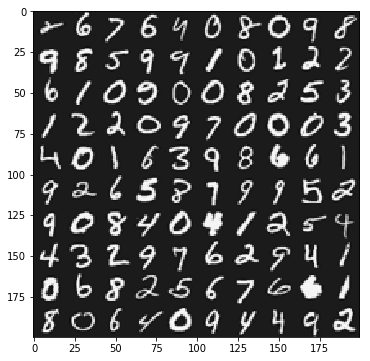

In [75]:
displayData()

#### 1.3 Vectorizing Logistic Regression

In [76]:
initial_thetaT = np.zeros((X.shape[1],1)).reshape(-1)
Theta = np.zeros((10,X.shape[1]))

print X.shape
print X.shape[1]
print np.zeros((X.shape[1],1)).reshape(-1).shape
print np.zeros((X.shape[1],1)).shape
print initial_thetaT.shape

(5000, 401)
401
(401,)
(401, 1)
(401,)


In [77]:
print np.dot(X,initial_thetaT)[0] #returns 0 for every item in the vector cuz initial_theta is all 0s
print expit(np.dot(X,initial_thetaT))[0] #returns 0.5 for every row cuz sigmoid of 0 is 0.5
print expit(np.dot(X,initial_thetaT)).shape #returns a vector length = len(training set)

0.0
0.5
(5000,)


In [78]:
#Hypothesis function and cost function for logistic regression
def h(mytheta,myX): #Logistic hypothesis function
    #Pretty simple & elegant...
    #myX ends up being the entire training set of (5000, 401)
    #mytheta ends up being a vector, (401,)
    #np.dot is smart enough to do vectorized dot products, so it does
    #the dot product row by row & returns a (5000,) vector for each x
    #expit then runs each of those 5000 values through the sigmoid function
    #See the cell above for how those calcs & shapes look
    return expit(np.dot(myX,mytheta))

#A more simply written cost function than last week, inspired by subokita:
def computeCost(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0] #5000
    myh = h(mytheta,myX) #shape: (5000,1)
    term1 = np.log( myh ).dot( -myy.T ) #shape: (5000,5000)
    term2 = np.log( 1.0 - myh ).dot( 1 - myy.T ) #shape: (5000,5000)
    left_hand = (term1 - term2) / m #shape: (5000,5000)
    right_hand = mytheta.T.dot( mytheta ) * mylambda / (2*m) #shape: (1,1)
    return left_hand + right_hand #shape: (5000,5000)

#### 1.4 One-vs-all Classification

In [79]:
#An alternative to OCTAVE's 'fmincg' we'll use some scipy.optimize function, "fmin_cg"
#This is more efficient with large number of parameters.
#In the previous homework, I didn't have to compute the cost gradient because
#the scipy.optimize function did it for me with some kind of interpolation...
#However, fmin_cg needs the gradient handed do it, so I'll implement that here
def costGradient(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0]
    #Tranpose y here because it makes the units work out in dot products later
    #(with the way I've written them, anyway)
    beta = h(mytheta,myX)-myy.T #shape: (5000,5000)

    #regularization skips the first element in theta
    regterm = mytheta[1:]*(mylambda/m) #shape: (400,1)

    grad = (1./m)*np.dot(myX.T,beta) #shape: (401, 5000)
    #regularization skips the first element in theta
    grad[1:] = grad[1:] + regterm
    return grad #shape: (401, 5000)

In [80]:
from scipy import optimize

def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.fmin_cg(computeCost, fprime=costGradient, x0=mytheta, \
                              args=(myX, myy, mylambda), maxiter=50, disp=False,\
                              full_output=True)
    return result[0], result[1]

Playing with the optimize function per https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cg.html#scipy.optimize.fmin_cg

For this simple function, it doesn't matter much if you take the derivative yourself and feed that as an arg to fmin_cg or leave it out. Well, doesn't matter in the sense that they're both super fast. But it is notable that even for a simple quadratic function, not specifying the derivative function triples the # function evaluations the algorithm needs. (It must be calculating the gradient around the starting current hypothesis.)

In [81]:
def squarex(x):
    return ((x**2)+x*3)

def twox(x):
    return (2*x+3)

tX = np.linspace(-100,100,num=201)
X0 = np.zeros(1)
X0[0] = 3
print X0

#test = optimize.fmin_cg(squarex, fprime=twox, x0=X0, maxiter=100)
test = optimize.fmin_cg(squarex, x0=X0, maxiter=100)

print test[0]

[ 3.]
Optimization terminated successfully.
         Current function value: -2.250000
         Iterations: 1
         Function evaluations: 9
         Gradient evaluations: 3
-1.50000048296


In [82]:
#Note: I spent a LONG time trying to optimize everything. Initially training 10 classes
#took about 5 minutes. Now I've got it down to taking ~5 seconds total!
def buildTheta():
    """
    Function that determines an optimized theta for each class
    and returns a Theta function where each row corresponds
    to the learned logistic regression params for one class
    """
    mylambda = 0.
    
    #Create the initial theta as a vector of 0s for the starting hypothesis
    #The shape-reshape seemed weird/cumbersome, but it works like this:
    # - X.shape[1] is the column dimension of X, 401 in this case (ie pixels per image + 1)
    # So that gives 401 rows to initial_theta at first
    # - the 1 after the comma puts 1 dimension of columns, ie every row has 1 a # vector
    #That's cool but it's not quite what we want. We want a vector of 401 items
    # - reshape -1 converts that (401, 1) matrix into a (401,) vector
    #That (401,) vector is what we need for initial_theta
    initial_theta = np.zeros((X.shape[1],1)).reshape(-1)
    
    #Then to do multiclass, we apparently need to update theta for each class
    #So we need a (10,401) matrix to hold all of Theta for 10 classes + 401 features
    Theta = np.zeros((10,X.shape[1]))
    
    for i in xrange(10):
        #I think this line is just to get around using for i in [1,2...10]
        #That does prove useful for the Theta matrix assignment 
        #(although could just have used i-1 I think)
        #('if i' returns false only when i == 0 so this works)
        iclass = i if i else 10 #class "10" corresponds to handwritten zero

        print "Optimizing for handwritten number %d..."%i
        
        #This is a very clever way to get the y vector, which starts as a random bunch of
        #digits for the correct handwritten value, into a binary vector for just the class
        #in question. They happen to be in order in the X matrix, so logic_Y has:
        # - for iclass == 0, it's a bunch of 1s then all zeros
        # - for iclass 1-8, it's 0s, then 1s, then zeros
        # - for iclass 9, it's all 0s then the 9s at the end become 1s
        #Pass that binary in as the y vector for the optimization at each iclass
        logic_Y = np.array([1 if x == iclass else 0 for x in y])#.reshape((X.shape[0],1))
        itheta, imincost = optimizeTheta(initial_theta,X,logic_Y,mylambda)
        
        #Store the vector of thetas at the index of each iclass
        Theta[i,:] = itheta
    print "Done!"
    return Theta

In [83]:
Theta = buildTheta()

Optimizing for handwritten number 0...
Optimizing for handwritten number 1...
Optimizing for handwritten number 2...
Optimizing for handwritten number 3...
Optimizing for handwritten number 4...
Optimizing for handwritten number 5...
Optimizing for handwritten number 6...
Optimizing for handwritten number 7...
Optimizing for handwritten number 8...
Optimizing for handwritten number 9...
Done!


In [84]:
def predictOneVsAll(myTheta,myrow):
    """
    Function that computes a hypothesis for an individual image (row in X)
    and returns the predicted integer corresponding to the handwritten image
    """
    #This is just a list [10, 1, 2...9] from which the hypothesis is picked
    classes = [10] + range(1,10)
    #This is just a 10 member list to store the hypotheses, i.e., the logistic probability 
    #predicted for each class for the given x
    hypots  = [0]*len(classes)

    #Compute a hypothesis for each possible outcome
    #Choose the maximum hypothesis to find result
    for i in xrange(len(classes)):
        hypots[i] = h(myTheta[i],myrow)

    #Choose the maximum hypothesis to find result
    #Return the value from classes based on the index of hypots
    return classes[np.argmax(np.array(hypots))]    

In [71]:
# "You should see that the training set accuracy is about 94.9%"
n_correct, n_total = 0., 0.
incorrect_indices = []
for irow in xrange(X.shape[0]):
    n_total += 1
    if predictOneVsAll(Theta,X[irow]) == y[irow]: 
        n_correct += 1
    else: incorrect_indices.append(irow)
print "Training set accuracy: %0.1f%%"%(100*(n_correct/n_total))

Training set accuracy: 89.2%


This was returning 94.5% until 21 May 17. Not sure why the change. My tinkering didn't change the code, and the same result returns on the unmodified version now, too.

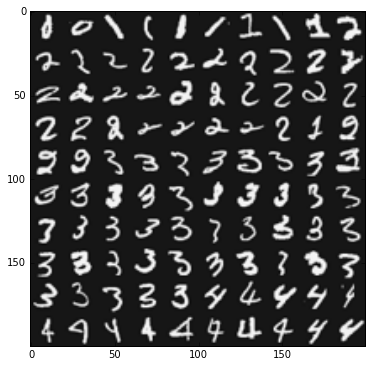

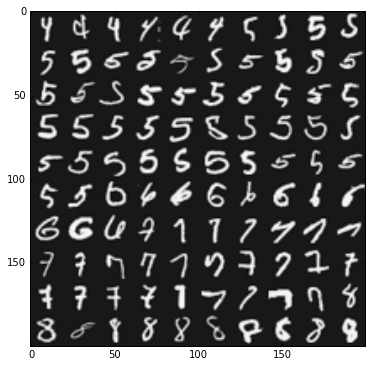

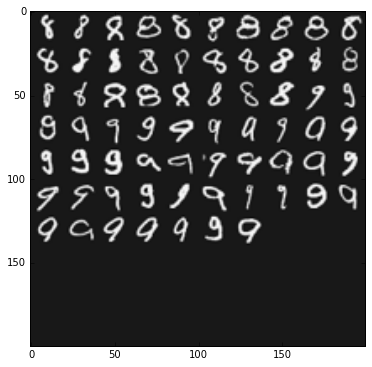

In [12]:
#Let's have a look at the ones we get wrong:
displayData(incorrect_indices[:100])
displayData(incorrect_indices[100:200])
displayData(incorrect_indices[200:300])

### Left off here on 21 May 17. Have multiclass logistic more or less figured out.
The next section does the prediction with neural network weights.
The weights themselves are magic till the following lesson.

### 2 Neural Networks

#### 2.1 Model representation

In [13]:
#You have been provided with a set of network parameters (Θ(1),Θ(2)) 
#already trained by us. These are stored in ex3weights.mat
datafile = 'data/ex3weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
print "Theta1 has shape:",Theta1.shape
print "Theta2 has shape:",Theta2.shape

Theta1 has shape: (25, 401)
Theta2 has shape: (10, 26)


#### 2.2 Feedforward Propagation

In [14]:
def propagateForward(row,Thetas):
    """
    Function that given a list of Thetas, propagates the
    Row of features forwards, assuming the features already
    include the bias unit in the input layer, and the 
    Thetas need the bias unit added to features between each layer
    """
    features = row
    for i in xrange(len(Thetas)):
        Theta = Thetas[i]
        z = Theta.dot(features)
        a = expit(z)
        if i == len(Thetas)-1:
            return a
        a = np.insert(a,0,1) #Add the bias unit
        features = a

def predictNN(row,Thetas):
    """
    Function that takes a row of features, propagates them through the
    NN, and returns the predicted integer that was hand written
    """
    classes = range(1,10) + [10]
    output = propagateForward(row,Thetas)
    return classes[np.argmax(np.array(output))]

In [15]:
# "You should see that the accuracy is about 97.5%"
myThetas = [ Theta1, Theta2 ]
n_correct, n_total = 0., 0.
incorrect_indices = []
#Loop over all of the rows in X (all of the handwritten images)
#and predict what digit is written. Check if it's correct, and
#compute an efficiency.
for irow in xrange(X.shape[0]):
    n_total += 1
    if predictNN(X[irow],myThetas) == int(y[irow]): 
        n_correct += 1
    else: incorrect_indices.append(irow)
print "Training set accuracy: %0.1f%%"%(100*(n_correct/n_total))

Training set accuracy: 97.5%


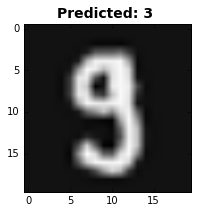

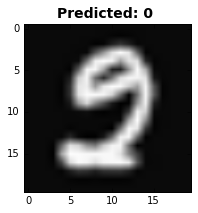

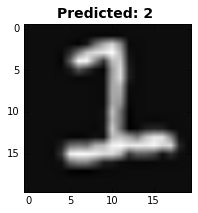

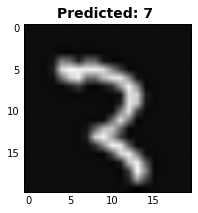

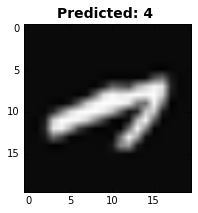

In [18]:
#Pick some of the images we got WRONG and look at them, just to see
for x in xrange(5):
    i = random.choice(incorrect_indices)
    fig = plt.figure(figsize=(3,3))
    img = scipy.misc.toimage( getDatumImg(X[i]) )
    plt.imshow(img,cmap = cm.Greys_r)
    predicted_val = predictNN(X[i],myThetas)
    predicted_val = 0 if predicted_val == 10 else predicted_val
    fig.suptitle('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')